In [166]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    fh = open(graph_path+str(file)+".txt", "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(nx.relabel_nodes(GRAPH, map))  
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(env, action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid):    
    figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(12, 10))
    #figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(22, 20))
    for i, graph_name in enumerate(file_list):
        GRAPH, map = input_graph(graph_path,graph_name)
        N = len(GRAPH)
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        print(graph_name)
        print(lcc_mix)
        print(lcc_ba)
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''


        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')

    figure.text(0.5, 0.03,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.04, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    plt.savefig("./Figure/"+title)
    plt.show()

# Synthetic Network:- Heterogeneity and Homogeneity

In [167]:

BA =  31500
MIX =  41500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


heterogeneous_30
[23, 21, 17, 10, 9, 6, 6, 6, 4, 3]
[23, 21, 17, 16, 11, 8, 4, 4, 2]
heterogeneous_50
[36, 33, 32, 31, 30, 28, 22, 16, 13, 6, 6, 6, 6, 4]
[36, 33, 31, 29, 28, 26, 16, 11, 11, 9, 4]
heterogeneous_100
[76, 74, 71, 70, 67, 64, 59, 56, 54, 39, 31, 14, 13, 13, 9]
[76, 74, 71, 70, 67, 62, 59, 56, 54, 39, 31, 14, 14, 13, 11]
heterogeneous_500
[414, 412, 411, 407, 405, 404, 402, 400, 397, 394, 390, 389, 386, 384, 382, 378, 376, 373, 371, 367, 362, 298, 297, 294, 290, 287, 286, 281, 278, 278, 277, 274, 256, 256, 254, 249, 248, 243, 241, 212, 210, 178, 178, 178, 178, 177, 100, 100, 83, 83, 81, 70, 70, 57]
[414, 412, 411, 407, 404, 402, 400, 399, 396, 391, 389, 388, 387, 386, 384, 381, 379, 378, 376, 373, 309, 308, 306, 305, 300, 299, 296, 292, 291, 287, 284, 179, 177, 177, 177, 177, 177, 177, 177, 177, 174, 171, 171, 171, 171, 171, 171, 171, 171, 158, 153, 151, 148, 148, 148, 148, 148, 148, 148, 148, 147, 145, 142, 142, 110, 110, 110, 110, 93, 93, 91, 91, 91, 78, 71, 71, 70, 56]


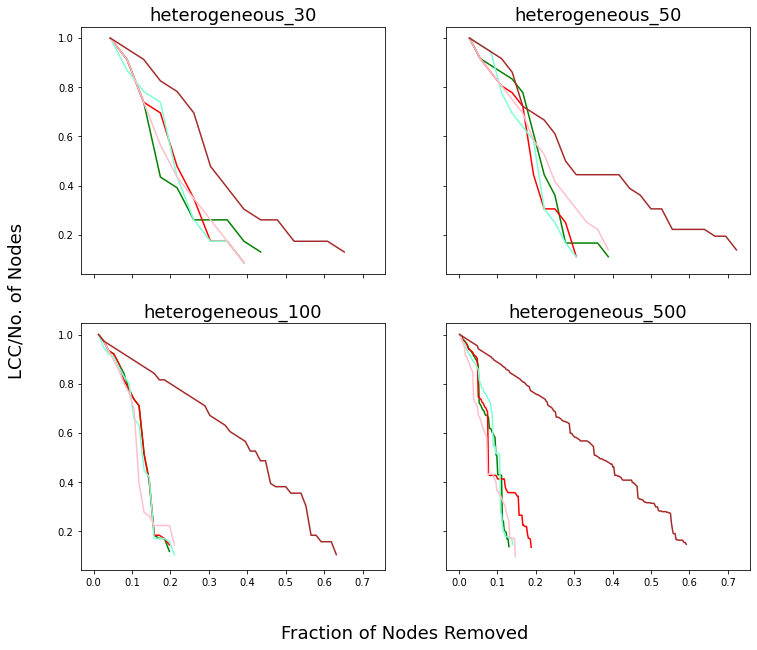

In [168]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"heterogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])


In [169]:

BA = 97000 
MIX = 27500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


homogeneous_30
[29, 27, 26, 25, 23, 17, 16, 14, 6, 6, 6, 4]
[29, 27, 26, 25, 24, 23, 22, 15, 10, 5, 5, 4]
homogeneous_50
[50, 49, 48, 47, 46, 45, 42, 39, 22, 22, 19, 9, 9, 9, 7]
[50, 49, 48, 47, 46, 45, 42, 40, 23, 23, 10, 10, 8, 8, 6]
homogeneous_100
[94, 92, 91, 90, 86, 85, 84, 83, 82, 80, 79, 68, 68, 66, 33, 33, 27, 24, 24, 24, 15, 14]
[94, 92, 91, 90, 86, 85, 84, 83, 81, 80, 79, 36, 36, 35, 32, 30, 30, 27, 22, 22, 21, 13]
homogeneous_500
[466, 464, 463, 462, 461, 459, 457, 455, 453, 452, 451, 450, 448, 447, 446, 445, 444, 443, 442, 441, 438, 436, 435, 433, 431, 429, 428, 282, 278, 276, 276, 142, 142, 142, 139, 138, 136, 136, 136, 136, 136, 134, 130, 130, 130, 130, 126, 126, 124, 124, 121, 121, 119, 117, 117, 117, 117, 116, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 84, 71, 71, 45]
[466, 464, 463, 461, 460, 459, 457, 455, 454, 452, 450, 449, 448, 443, 442, 441, 440, 439, 436, 435, 433, 430, 429, 427, 424, 274, 274, 274, 274, 274, 142, 142, 141, 140, 140, 138, 136, 1

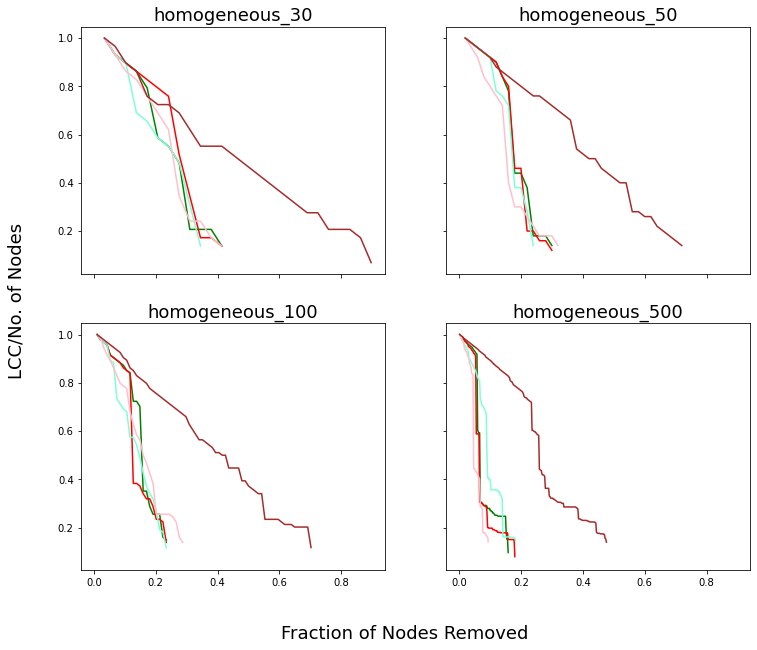

In [170]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"homogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])

# Synthetic with Motifs Attached

In [160]:

BA = 122500
MIX = 6500
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


ba_300_20_house_1
[400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 367, 366, 364, 363, 352, 351, 350, 348, 347, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 327, 325, 324, 323, 322, 320, 319, 318, 314, 313, 312, 311, 310, 309, 307, 306, 305, 304, 303, 302, 296, 290, 289, 285, 279, 277, 276, 261, 258, 252, 250, 249, 248, 246, 245, 244, 243, 242, 239, 236, 235, 233, 230, 222, 211, 210, 197, 190, 189, 188, 187, 186, 109, 105, 105, 105, 105, 76, 76, 76, 76, 73, 63, 37]
[400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 367, 366, 365, 364, 362, 351, 350, 348, 347, 346, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 327, 325, 324, 323, 322, 321, 319, 318, 317, 316, 315, 311, 309, 308, 307, 306, 305, 304, 303, 300, 299, 293, 292, 286, 280, 279, 272, 271, 268, 265, 248, 247, 245, 239, 237, 23

ba_300_60_fan_3
[360, 358, 357, 356, 355, 354, 353, 352, 351, 349, 348, 347, 346, 345, 344, 343, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 330, 329, 327, 325, 324, 322, 320, 318, 317, 316, 315, 314, 312, 311, 308, 306, 304, 302, 301, 299, 297, 296, 295, 294, 293, 291, 290, 289, 287, 283, 282, 281, 280, 278, 277, 275, 274, 270, 268, 267, 265, 264, 262, 259, 258, 257, 256, 255, 254, 252, 251, 250, 248, 246, 245, 244, 243, 239, 238, 237, 233, 229, 227, 226, 224, 222, 214, 213, 212, 211, 210, 209, 208, 207, 206, 205, 199, 194, 190, 175, 173, 169, 165, 157, 155, 148, 145, 131, 131, 122, 119, 110, 109, 86, 75, 75, 43]
[360, 358, 357, 356, 355, 354, 353, 352, 351, 350, 348, 347, 346, 345, 344, 343, 342, 341, 340, 338, 337, 336, 335, 334, 333, 332, 331, 329, 327, 325, 323, 322, 321, 319, 318, 317, 315, 313, 312, 311, 309, 308, 306, 304, 303, 300, 298, 297, 296, 294, 293, 292, 291, 289, 285, 283, 282, 281, 279, 278, 277, 275, 273, 272, 268, 267, 265, 263, 260, 259, 258, 257, 254, 252, 2

ba_300_100_clique_5
[301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 240, 238, 236, 234, 233, 232, 231, 229, 227, 226, 225, 224, 222, 221, 220, 217, 214, 212, 211, 210, 208, 207, 206, 205, 203, 202, 201, 200, 198, 197, 194, 193, 189, 186, 183, 182, 181, 179, 178, 175, 172, 171, 170, 169, 168, 167, 165, 156, 155, 147, 145, 140, 135, 123, 62, 62, 62, 62, 49, 43]
[301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 240, 238, 236, 234, 232, 230, 229, 228, 227, 225, 224, 223, 222, 221, 219, 216, 214, 213, 211, 209, 208,

ba_300_20_cycle_1
[340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 327, 326, 325, 324, 323, 322, 321, 320, 319, 317, 316, 315, 314, 313, 312, 310, 309, 308, 307, 305, 303, 302, 301, 300, 299, 298, 297, 295, 294, 292, 291, 290, 289, 288, 287, 285, 284, 283, 281, 280, 279, 278, 275, 274, 273, 270, 269, 268, 267, 265, 264, 262, 260, 259, 258, 257, 255, 252, 251, 250, 243, 242, 240, 238, 237, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 207, 200, 197, 195, 193, 191, 190, 184, 182, 179, 177, 175, 167, 162, 160, 159, 157, 155, 151, 133, 129, 117, 117, 105, 99, 68, 34]
[340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 327, 326, 325, 324, 323, 322, 321, 320, 319, 317, 316, 315, 314, 313, 311, 310, 309, 308, 307, 305, 304, 303, 301, 300, 299, 298, 296, 295, 294, 292, 291, 290, 289, 288, 286, 284, 282, 281, 280, 279, 278, 276, 275, 274, 271, 268, 267, 265, 264, 263, 262, 260, 259, 258, 257, 255, 253, 252, 251, 248, 247, 245, 244, 243, 242, 240, 238, 237, 235, 234, 233, 231, 230

ba_300_80_star_4
[380, 379, 377, 376, 374, 372, 371, 370, 369, 368, 367, 366, 363, 361, 360, 358, 357, 356, 354, 353, 352, 351, 350, 348, 346, 345, 344, 342, 341, 340, 339, 337, 336, 335, 333, 331, 330, 329, 328, 326, 325, 324, 323, 322, 321, 319, 318, 317, 316, 313, 312, 309, 308, 306, 304, 303, 300, 298, 297, 296, 293, 292, 291, 289, 287, 286, 285, 284, 283, 282, 280, 277, 275, 273, 266, 264, 261, 259, 257, 255, 254, 249, 248, 247, 246, 245, 244, 241, 240, 239, 237, 235, 232, 230, 227, 223, 217, 215, 211, 209, 208, 207, 203, 201, 199, 193, 189, 183, 180, 176, 120, 93, 60, 60, 60, 60, 60, 36]
[380, 379, 377, 376, 374, 372, 371, 370, 369, 368, 367, 366, 363, 362, 360, 359, 357, 356, 354, 353, 352, 351, 350, 348, 346, 345, 344, 343, 341, 340, 339, 338, 336, 334, 333, 332, 330, 329, 328, 327, 326, 324, 322, 321, 320, 319, 318, 315, 314, 311, 310, 308, 307, 305, 303, 300, 297, 296, 295, 294, 293, 292, 291, 289, 286, 285, 283, 282, 280, 279, 278, 277, 276, 273, 270, 268, 266, 264, 262, 260

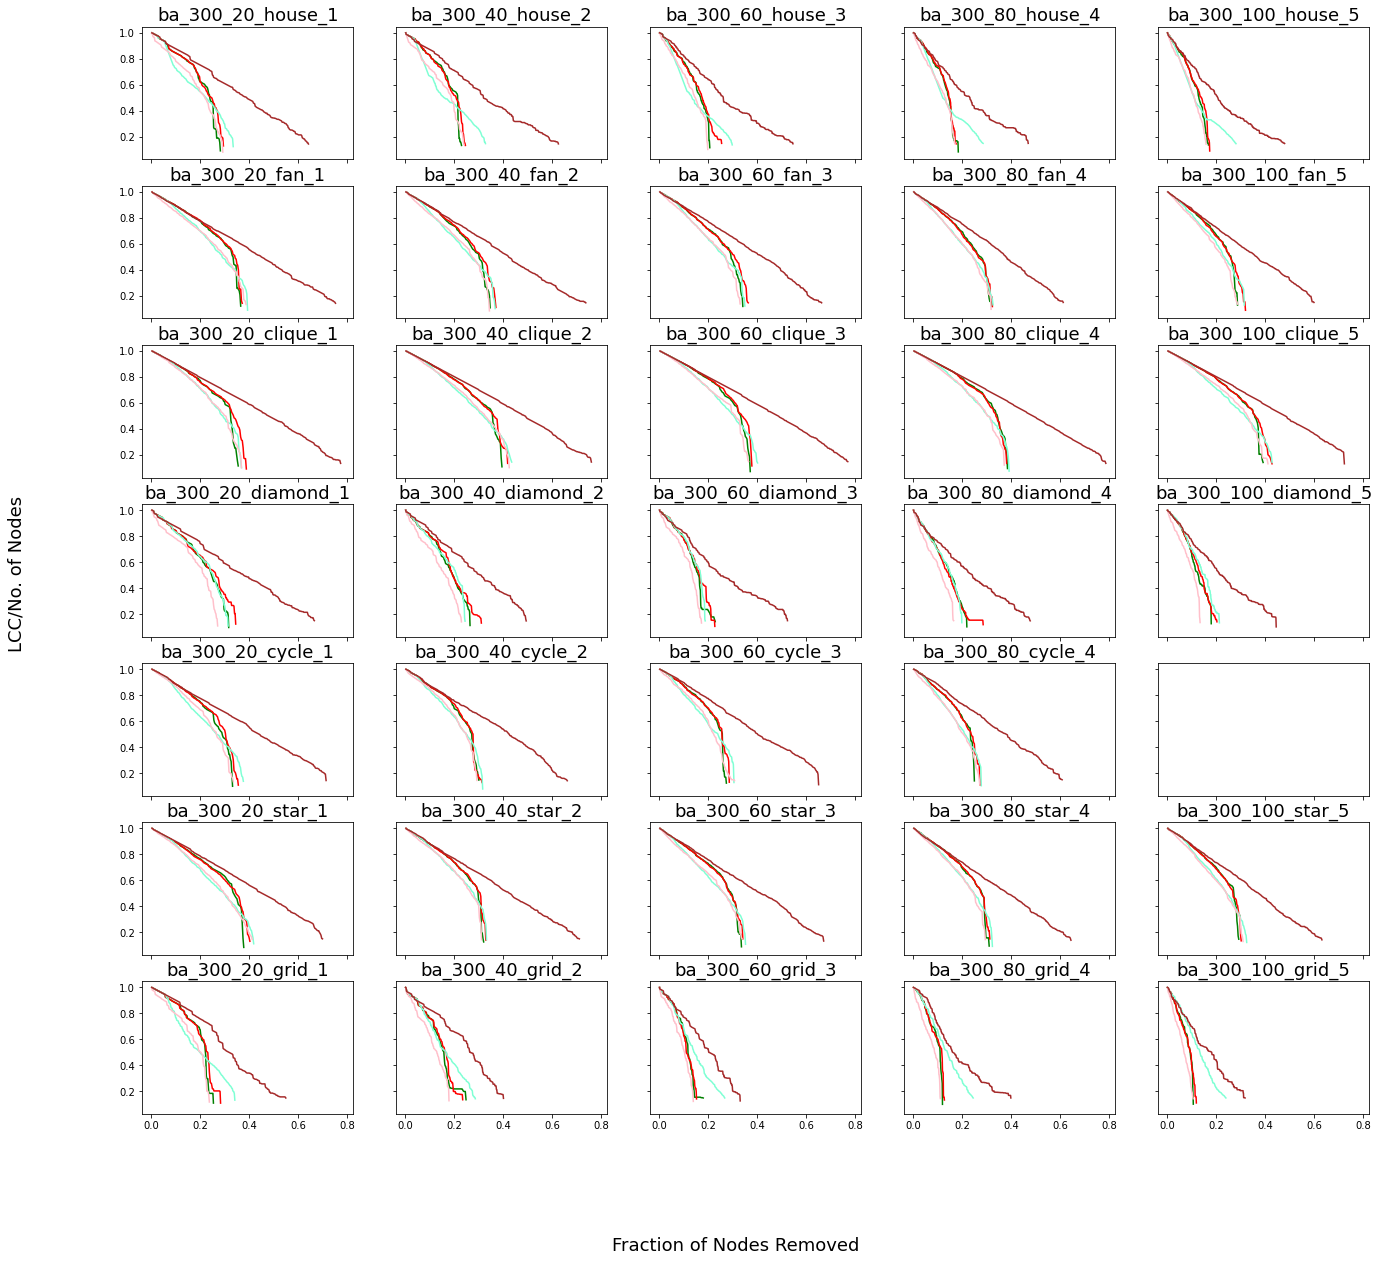

In [161]:
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


In [162]:

BA = 165000
MIX =479500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


tree_8_20_house_1
[611, 609, 608, 607, 603, 602, 601, 568, 566, 555, 553, 552, 539, 519, 518, 517, 493, 492, 491, 490, 483, 480, 479, 455, 454, 453, 450, 441, 433, 399, 397, 396, 396, 395, 372, 372, 365, 363, 363, 362, 359, 321, 303, 288, 285, 285, 282, 273, 273, 273, 263, 263, 254, 251, 243, 176, 176, 176, 167, 167, 160, 160, 160, 156, 156, 151, 109, 104, 104, 104, 104, 104, 87]
[611, 609, 604, 603, 588, 587, 586, 580, 575, 574, 572, 569, 566, 564, 561, 559, 544, 542, 540, 536, 528, 525, 513, 511, 510, 502, 495, 486, 485, 461, 460, 452, 450, 423, 420, 412, 403, 380, 356, 351, 344, 329, 326, 323, 312, 312, 303, 291, 291, 286, 281, 281, 276, 263, 263, 244, 226, 218, 202, 108, 108, 108, 108, 100, 100, 77]
tree_8_40_house_2
[711, 710, 709, 708, 707, 705, 700, 695, 693, 690, 687, 686, 685, 678, 675, 674, 673, 672, 670, 669, 666, 663, 654, 649, 647, 639, 632, 630, 622, 621, 620, 619, 613, 602, 601, 599, 597, 596, 569, 558, 551, 549, 528, 523, 522, 505, 497, 495, 483, 465, 457, 413, 405, 400

tree_8_20_clique_1
[512, 510, 508, 507, 506, 503, 497, 494, 476, 473, 470, 462, 460, 459, 458, 457, 455, 453, 445, 443, 441, 440, 438, 436, 420, 411, 404, 402, 399, 374, 361, 343, 339, 339, 336, 329, 325, 321, 318, 292, 288, 267, 259, 251, 251, 230, 221, 221, 221, 220, 195, 179, 145, 70]
[512, 511, 510, 507, 504, 502, 499, 495, 485, 477, 474, 459, 457, 454, 452, 451, 443, 436, 428, 410, 408, 407, 406, 402, 398, 391, 387, 374, 371, 364, 361, 351, 338, 338, 338, 330, 322, 322, 321, 309, 182, 170, 170, 169, 123, 123, 123, 123, 123, 114, 114, 102, 99, 87, 87, 87, 84, 84, 84, 84, 84, 84, 84, 81, 70]
tree_8_40_clique_2
[512, 511, 509, 507, 505, 503, 502, 500, 483, 472, 471, 447, 446, 445, 443, 440, 423, 422, 419, 416, 413, 412, 411, 408, 406, 404, 393, 390, 388, 277, 243, 236, 229, 226, 226, 177, 177, 169, 162, 162, 162, 120, 120, 120, 120, 104, 104, 77, 65]
[512, 511, 510, 508, 506, 502, 487, 485, 482, 467, 464, 461, 460, 457, 449, 446, 444, 442, 441, 437, 434, 427, 426, 419, 411, 408, 406,

tree_8_100_diamond_5
[1111, 1110, 1109, 1107, 1105, 1104, 1103, 1102, 1100, 1098, 1097, 1095, 1088, 1087, 1079, 1077, 1075, 1074, 1072, 1071, 1069, 1068, 1067, 1066, 1065, 1063, 1061, 1059, 1058, 1057, 1056, 1055, 1048, 1046, 1040, 1034, 1033, 1032, 1031, 1029, 1028, 1027, 1026, 1020, 1019, 1017, 1016, 1014, 1013, 1010, 1008, 1005, 1003, 997, 996, 995, 994, 988, 987, 984, 975, 974, 972, 970, 969, 967, 965, 963, 962, 955, 948, 946, 943, 939, 937, 927, 926, 925, 924, 921, 914, 912, 908, 907, 906, 878, 877, 865, 861, 847, 846, 837, 836, 835, 826, 825, 823, 822, 821, 820, 819, 796, 793, 767, 765, 764, 762, 746, 740, 737, 736, 729, 728, 700, 698, 694, 693, 692, 683, 671, 648, 637, 624, 623, 620, 613, 596, 577, 567, 558, 558, 556, 541, 541, 539, 537, 529, 422, 411, 411, 385, 385, 338, 338, 320, 308, 209, 199, 199, 191, 191, 191, 191, 191, 191, 191, 191, 182, 118]
[1111, 1110, 1109, 1103, 1102, 1096, 1095, 1094, 1093, 1091, 1087, 1086, 1084, 1083, 1082, 1081, 1080, 1079, 1078, 1077, 1076, 107

tree_8_40_grid_2
[1951, 1949, 1947, 1946, 1945, 1944, 1943, 1942, 1940, 1939, 1938, 1937, 1936, 1935, 1934, 1933, 1931, 1930, 1929, 1927, 1926, 1925, 1924, 1923, 1921, 1920, 1919, 1918, 1917, 1912, 1911, 1910, 1909, 1907, 1906, 1905, 1904, 1903, 1902, 1901, 1900, 1899, 1898, 1897, 1895, 1894, 1893, 1892, 1890, 1889, 1888, 1887, 1885, 1881, 1879, 1878, 1877, 1876, 1875, 1874, 1873, 1872, 1871, 1870, 1869, 1868, 1867, 1866, 1864, 1863, 1862, 1861, 1860, 1859, 1858, 1857, 1856, 1855, 1854, 1853, 1852, 1851, 1850, 1849, 1847, 1846, 1845, 1844, 1843, 1842, 1841, 1840, 1839, 1838, 1837, 1835, 1834, 1833, 1831, 1830, 1829, 1828, 1827, 1826, 1825, 1824, 1823, 1822, 1821, 1819, 1818, 1817, 1816, 1814, 1812, 1804, 1802, 1801, 1800, 1798, 1797, 1796, 1795, 1794, 1792, 1791, 1790, 1789, 1786, 1784, 1783, 1782, 1781, 1780, 1778, 1777, 1776, 1774, 1773, 1772, 1771, 1770, 1768, 1766, 1765, 1764, 1763, 1762, 1761, 1760, 1759, 1758, 1756, 1754, 1753, 1752, 1751, 1750, 1747, 1746, 1745, 1744, 1742, 1741

tree_8_80_grid_4
[3391, 3390, 3389, 3388, 3386, 3385, 3384, 3383, 3382, 3380, 3379, 3377, 3376, 3375, 3374, 3373, 3372, 3371, 3370, 3369, 3368, 3367, 3366, 3365, 3364, 3363, 3362, 3361, 3360, 3359, 3358, 3357, 3355, 3354, 3352, 3351, 3350, 3349, 3348, 3347, 3346, 3344, 3343, 3342, 3340, 3339, 3338, 3333, 3332, 3331, 3330, 3328, 3327, 3326, 3324, 3323, 3322, 3321, 3320, 3318, 3317, 3316, 3315, 3314, 3313, 3312, 3311, 3310, 3309, 3307, 3306, 3304, 3303, 3302, 3301, 3299, 3298, 3297, 3296, 3295, 3293, 3291, 3290, 3289, 3288, 3287, 3286, 3285, 3283, 3281, 3280, 3278, 3277, 3274, 3273, 3272, 3270, 3269, 3267, 3265, 3264, 3263, 3262, 3261, 3260, 3259, 3257, 3256, 3255, 3254, 3253, 3251, 3250, 3248, 3247, 3246, 3245, 3244, 3243, 3240, 3238, 3236, 3235, 3234, 3233, 3232, 3231, 3230, 3229, 3228, 3226, 3225, 3223, 3222, 3221, 3220, 3219, 3218, 3217, 3216, 3215, 3214, 3213, 3212, 3211, 3210, 3209, 3207, 3206, 3205, 3204, 3203, 3201, 3199, 3198, 3196, 3195, 3194, 3193, 3192, 3191, 3190, 3189, 3188

tree_8_100_grid_5
[4111, 4110, 4109, 4108, 4107, 4106, 4105, 4104, 4103, 4102, 4101, 4100, 4099, 4098, 4097, 4096, 4095, 4094, 4093, 4092, 4091, 4090, 4089, 4087, 4085, 4084, 4083, 4082, 4081, 4080, 4079, 4078, 4077, 4076, 4075, 4074, 4073, 4072, 4071, 4070, 4068, 4066, 4065, 4064, 4063, 4062, 4061, 4060, 4059, 4058, 4056, 4055, 4054, 4052, 4051, 4050, 4049, 4047, 4046, 4045, 4044, 4043, 4042, 4041, 4040, 4038, 4036, 4034, 4033, 4032, 4031, 4030, 4028, 4027, 4025, 4023, 4022, 4020, 4019, 4018, 4017, 4015, 4014, 4012, 4011, 4010, 4009, 4008, 4007, 4006, 4005, 4004, 4003, 4002, 4001, 3999, 3998, 3996, 3994, 3993, 3992, 3991, 3990, 3989, 3988, 3987, 3986, 3985, 3984, 3983, 3982, 3981, 3979, 3978, 3977, 3976, 3974, 3972, 3971, 3970, 3969, 3968, 3967, 3966, 3965, 3964, 3963, 3962, 3961, 3960, 3959, 3958, 3957, 3956, 3955, 3954, 3953, 3952, 3950, 3949, 3948, 3946, 3945, 3944, 3943, 3942, 3941, 3940, 3939, 3938, 3937, 3936, 3935, 3933, 3932, 3931, 3930, 3929, 3928, 3927, 3926, 3925, 3924, 392

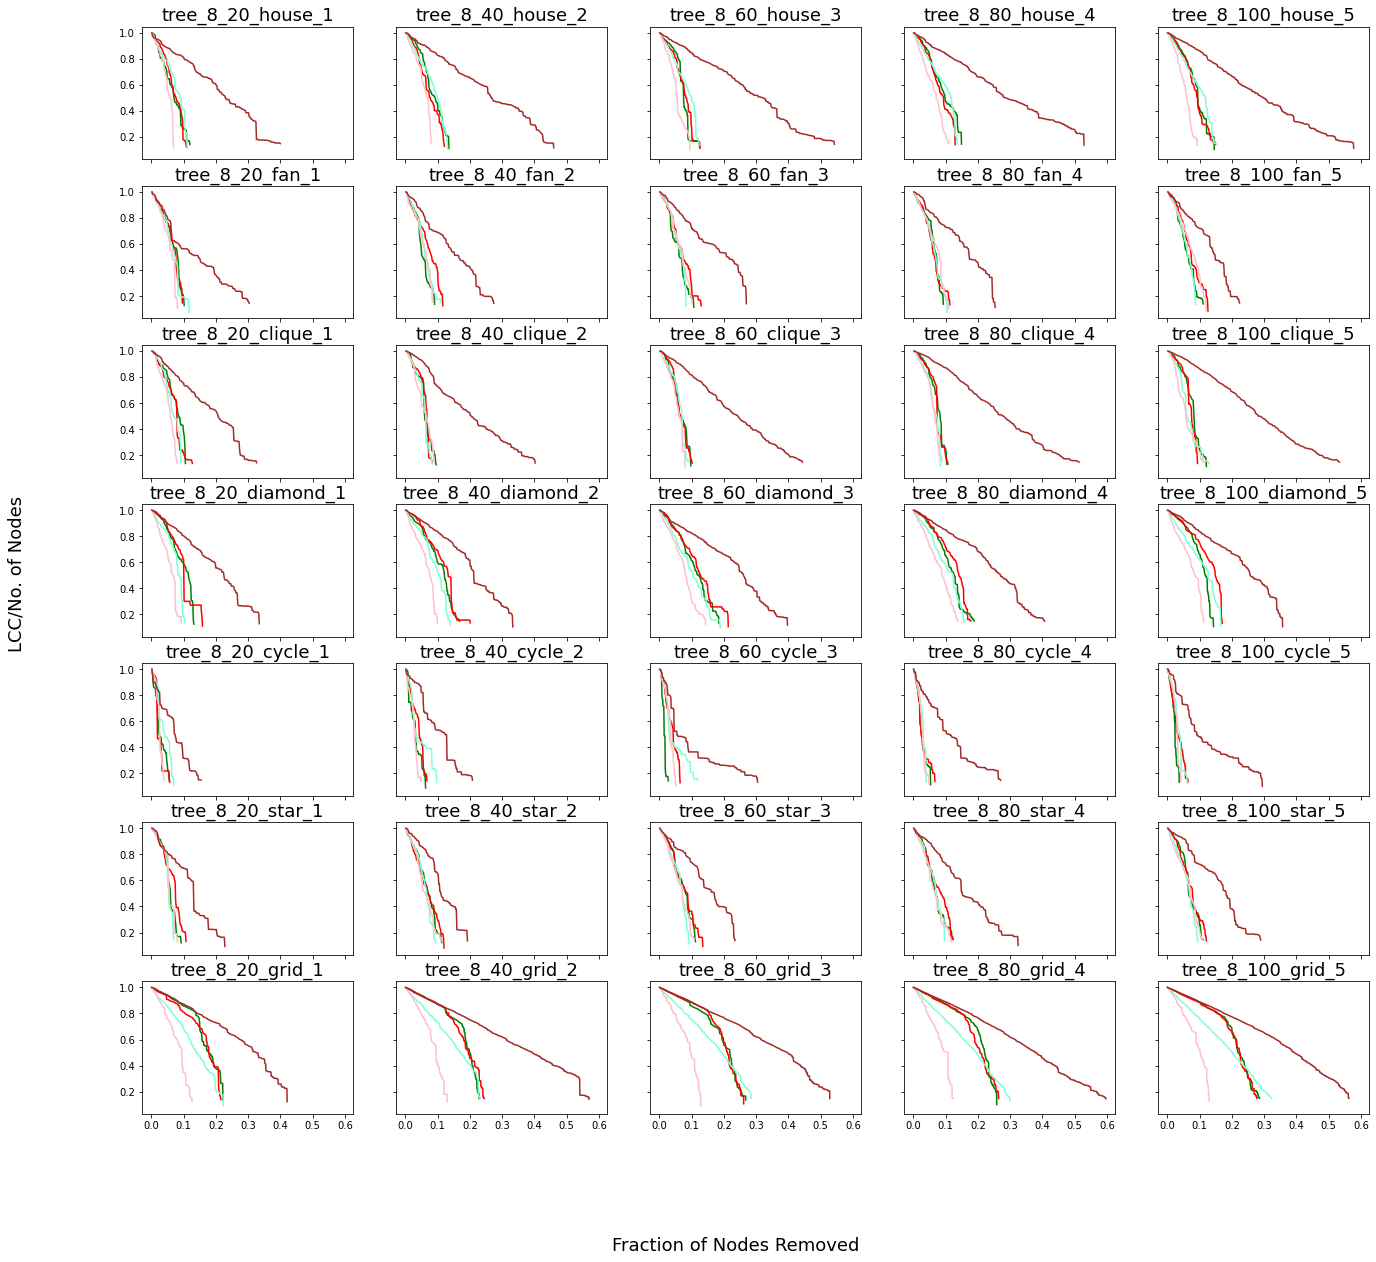

In [163]:
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


## Cancer Gene

COAD
[4120, 4093, 4086, 4080, 4062, 4040, 4035, 4028, 4007, 3966, 3965, 3962, 3961, 3957, 3935, 3922, 3915, 3911, 3903, 3902, 3893, 3892, 3889, 3886, 3884, 3883, 3881, 3880, 3873, 3871, 3868, 3860, 3854, 3853, 3850, 3849, 3846, 3828, 3826, 3816, 3812, 3810, 3808, 3800, 3798, 3782, 3780, 3777, 3772, 3765, 3750, 3744, 3732, 3718, 3716, 3715, 3714, 3711, 3709, 3671, 3669, 3668, 3658, 3652, 3644, 3641, 3635, 3630, 3628, 3621, 3616, 3614, 3611, 3604, 3596, 3594, 3588, 3578, 3577, 3567, 3566, 3564, 3551, 3544, 3542, 3532, 3531, 3530, 3513, 3507, 3501, 3496, 3487, 3472, 3467, 3465, 3462, 3460, 3440, 3438, 3435, 3390, 3389, 3385, 3383, 3380, 3378, 3361, 3359, 3358, 3353, 3348, 3346, 3345, 3342, 3341, 3340, 3334, 3332, 3330, 3325, 3319, 3314, 3309, 3308, 3300, 3299, 3297, 3295, 3293, 3290, 3289, 3288, 3285, 3278, 3277, 3276, 3274, 3272, 3271, 3269, 3267, 3262, 3259, 3258, 3253, 3252, 3250, 3249, 3248, 3247, 3244, 3241, 3234, 3227, 3221, 3211, 3207, 3206, 3205, 3204, 3200, 3198, 3196, 3192, 3190

HNSC
[5116, 5114, 5113, 5112, 5111, 5110, 5108, 5107, 5106, 5105, 5104, 5102, 5099, 5097, 5096, 5094, 5093, 5092, 5091, 5090, 5088, 5087, 5085, 5084, 5081, 5080, 5079, 5078, 5077, 5076, 5075, 5070, 5068, 5067, 5066, 5065, 5064, 5061, 5060, 5050, 5049, 5047, 5045, 5043, 5041, 4985, 4984, 4983, 4982, 4981, 4980, 4979, 4978, 4976, 4975, 4972, 4971, 4970, 4969, 4968, 4967, 4965, 4964, 4962, 4961, 4960, 4959, 4954, 4953, 4952, 4951, 4949, 4947, 4943, 4942, 4941, 4939, 4938, 4935, 4933, 4932, 4931, 4930, 4919, 4918, 4917, 4916, 4915, 4910, 4906, 4904, 4903, 4902, 4900, 4899, 4898, 4897, 4893, 4892, 4881, 4880, 4876, 4875, 4873, 4872, 4871, 4868, 4865, 4853, 4849, 4848, 4845, 4840, 4839, 4838, 4836, 4826, 4825, 4795, 4793, 4792, 4791, 4785, 4782, 4780, 4778, 4776, 4773, 4772, 4771, 4770, 4769, 4768, 4767, 4766, 4765, 4764, 4763, 4761, 4684, 4675, 4674, 4672, 4663, 4656, 4655, 4654, 4639, 4637, 4635, 4633, 4625, 4620, 4613, 4611, 4603, 4602, 4593, 4591, 4585, 4583, 4580, 4576, 4565, 4555, 4554

KICH
[2273, 1918, 1918, 1918, 1918, 1918, 1886, 1886, 1873, 1861, 1861, 1860, 1855, 1794, 1794, 1787, 1784, 1784, 1764, 1764, 1760, 1738, 1738, 1704, 1697, 1697, 1622, 1619, 1614, 1614, 1612, 1611, 1611, 1605, 1577, 1568, 1568, 1557, 1555, 1554, 1552, 1544, 1544, 1544, 1541, 1528, 1525, 1523, 1504, 1503, 1502, 1500, 1497, 1459, 1457, 1445, 1434, 1432, 1423, 1422, 1422, 1421, 1415, 1414, 1406, 1390, 1386, 1351, 1332, 1330, 1328, 1317, 1315, 1300, 1282, 1258, 1255, 1236, 1220, 1220, 1212, 1207, 1205, 1192, 1169, 1158, 1157, 1153, 1152, 1152, 1143, 1133, 1127, 1122, 1111, 1108, 1096, 1083, 1075, 1036, 1034, 1031, 1017, 990, 946, 937, 931, 900, 883, 879, 879, 865, 855, 852, 847, 847, 845, 843, 843, 840, 732, 727, 725, 645, 645, 633, 633, 629, 627, 627, 618, 590, 590, 579, 578, 566, 565, 557, 554, 554, 554, 553, 552, 552, 549, 545, 545, 544, 534, 532, 525, 508, 508, 506, 506, 483, 483, 477, 477, 474, 389, 329]
[2273, 1918, 1918, 1918, 1918, 1918, 1886, 1886, 1852, 1831, 1787, 1787, 1725, 16

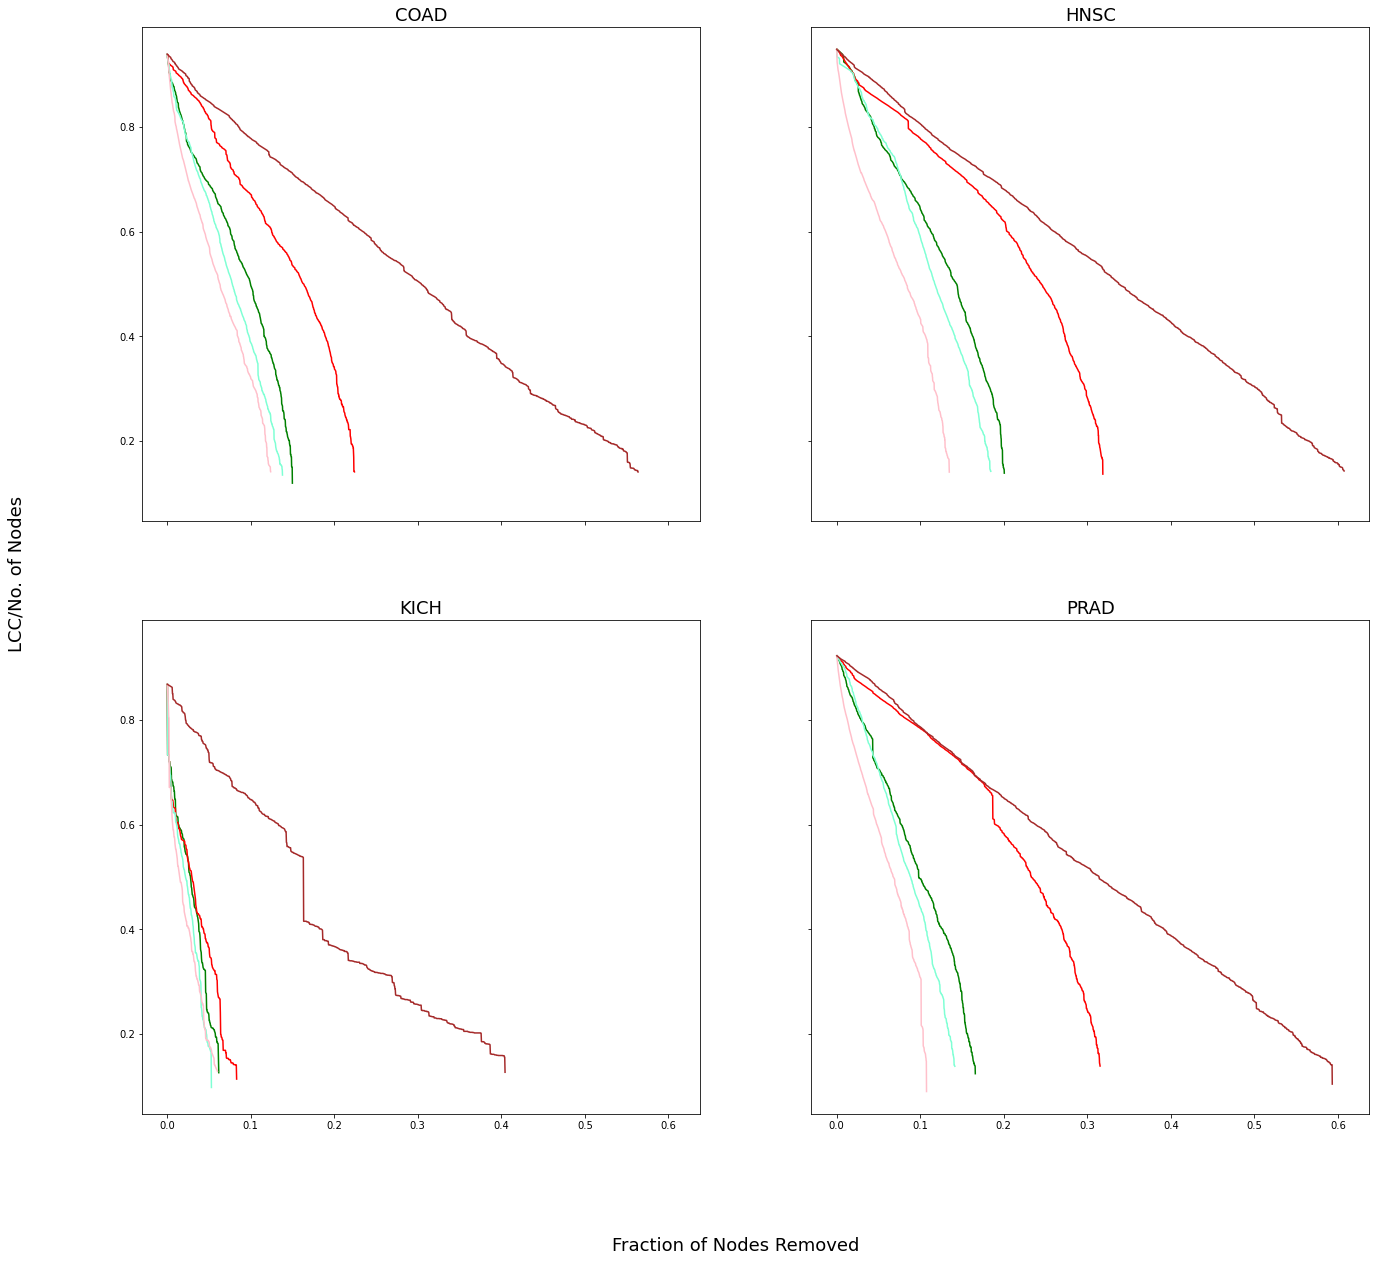

In [164]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD"]
x, y = 2, 2
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])